# Computational Improve

The generic splicing technique certifiably guarantees the best subset can be selected in a polynomial time. In practice, the computational efficiency can be improved to handle large scale datasets. The tips for computational improvement include:

- exploit sparse strucute of input matrix;
- use golden-section to search best support size;
- early-stop scheme;
- sure independence screening;
- warm-start initialization;
- parallel computing when performing cross validation;
- covariance update for `abessLm` or `abessMultigaussian`;
- approximate Newton iteration for `abessLogistic`, `abessPoisson`, `abessCox`.

This vignette illustrate the first two tips. For the other tips, they have been efficiently implemented and set as the default in abess package.

## Sparse matrix

We sometimes meet with problems where the $N×p$ input matrix $X$ is extremely sparse, i.e., many entries in $X$ have zero values. A notable example comes from document classification: aiming to assign classes to a document, making it easier to manage for publishers and news sites. The input variables for characterizing documents are generated from a so called "bag-of-words" model. In this model, each variable is scored for the presence of each of the words in the entire dictionary under consideration. Since most words are absent, the input variables for each document is mostly zero, and so the entire matrix is mostly zero. 

For example, we create a sparse matrix like:

In [1]:
from scipy.sparse import coo_matrix
import numpy as np

row  = np.array([0, 1, 2, 3, 4, 4,  5, 6, 7, 7, 8, 9])
col  = np.array([0, 3, 1, 2, 4, 3, 5, 2, 3, 1, 5, 2])
data = np.array([4, 5, 7, 9, 1, 23, 4, 5, 6, 8, 77, 100])
x = coo_matrix((data, (row, col)))

print(x.toarray())

[[  4   0   0   0   0   0]
 [  0   0   0   5   0   0]
 [  0   7   0   0   0   0]
 [  0   0   9   0   0   0]
 [  0   0   0  23   1   0]
 [  0   0   0   0   0   4]
 [  0   0   5   0   0   0]
 [  0   8   0   6   0   0]
 [  0   0   0   0   0  77]
 [  0   0 100   0   0   0]]


The sparse matrix can be directly used in `abess` pacakages. We just need to set argument `sparse_matrix = T`. Note that if the input matrix is not sparse matrix, the program would automatically transfer it into the sparse one, so this argument can also make some improvement.

In [2]:
from abess import abessLm

coef = np.array([1, 1, 1, 0, 0, 0])
y = x.dot(coef)
model = abessLm(sparse_matrix = True)
model.fit(x, y)

print("real coef: \n", coef)
print("pred coef: \n", model.coef_)


real coef: 
 [1 1 1 0 0 0]
pred coef: 
 [1. 1. 1. 0. 0. 0.]


We compare the runtime when the input matrix is dense matrix:

In [23]:
from time import time

t = time()
model = abessLm()
model.fit(x.toarray(), y)
print("dense matrix:  ", time() - t)

t = time()
model = abessLm(sparse_matrix = True)
model.fit(x, y)
print("sparse matrix:  ", time() - t)

dense matrix:   0.0013453960418701172
sparse matrix:   0.0006170272827148438


From the comparison, we see that the time required by sparse matrix is smaller, and this sould be more visible when the sparse imput matrix is large. Hence, we suggest to assign a sparse matrix to `abess` when the input matrix have a lot of zero entries.

## Golden-section searching

Here we generate a simple example and draw the path of scores of information criterion. Typically, the curve should be a strictly unimodal function achieving minimum at the true subset size.

lowest point:  5


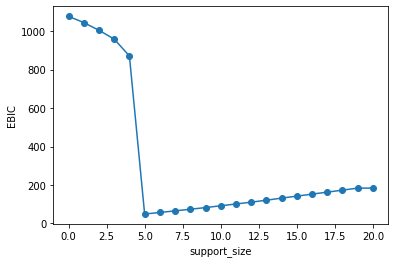

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from abess import gen_data

np.random.seed(0)
data = gen_data(n = 100, p = 20, k = 5, family = 'gaussian')

ic = np.zeros(21)
for sz in range(21):
    model = abessLm(support_size = [sz], ic_type = 'ebic')
    model.fit(data.x, data.y)
    ic[sz] = model.ic_

print("lowest point: ", np.argmin(ic))
plt.plot(ic, 'o-')
plt.xlabel('support_size')
plt.ylabel('EBIC')
plt.show()

Here the generated data contains 100 observations with 20 predictors, while 5 of them are useful (should be non-zero). The default information criterion is EBIC. From the figure, we can find that "support_size = 5" is the lowest point.

Compared with searching the optimal support size one by one from a candidate set with $O(s_{max})$ complexity, **golden-section** reduce the time complexity to $O(ln(s_{max}))$, giving a significant computational improvement.

In `abess` package, this can be easily formed like:

In [5]:
model = abessLm(path_type = 'pgs', s_min = 0, s_max = 20)
model.fit(data.x, data.y)
print("real coef:\n", np.nonzero(data.coef_)[0])
print("predicted coef:\n", np.nonzero(model.coef_)[0])

real coef:
 [ 2  5 10 11 18]
predicted coef:
 [ 2  5 10 11 18]


where `path_type = pgs` means golden-section and `s_min`, `s_max` indicates the left and right bound of range of the support size. Note that in golden-section searching, we should not give `support_size`, which is only useful for sequential strategy.

The output of golden-section strategy suggests the optimal model size is accurately detected. Compare to the sequential searching, the golden section reduce the runtime because it skip some support sizes which are likely to be a non-optimal one:

In [6]:
from time import time

t1 = time()
model = abessLm(support_size = range(21))
model.fit(data.x, data.y)
print("sequential time: ", time() - t1)

t2 = time()
model = abessLm(path_type = 'pgs', s_min = 0, s_max = 20)
model.fit(data.x, data.y)
print("golden-section time: ", time() - t2)

sequential time:  0.004273414611816406
golden-section time:  0.0021483898162841797


The golden-section runs much faster than sequential method, espectially when the range of support size is large.